In [1]:
from __future__ import annotations
import numpy as np
from typing import *
import copy
from scipy.special import gammaln
import scipy.misc
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os
import benchmark_functions as bf
from timeit import default_timer as timer

In [2]:
class MetricCollector:
    def __init__(self, name: str = None, run_id: int = None):
        self.name = name
        self.run_id = run_id

        self.best_individual_cost_each_gen = []
        self.avg_cost_each_gen = []

        self.best_elite_individual_cost_each_gen = []
        self.avg_elite_cost_each_gen = []

        self.best_middle_individual_cost_each_gen = []
        self.avg_middle_cost_each_gen = []

        self.best_lower_individual_cost_each_gen = []
        self.avg_lower_cost_each_gen = []
        self.iter_reached_vtr = -1
        self.nfev = 0
        self.time = -1

    def collect_all(self, best_individual_fitness: float, avg_fitness: float):
        self.best_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_cost_each_gen.append(avg_fitness)

    def collect_elite(self, best_individual_fitness: float, avg_fitness: float):
        self.best_elite_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_elite_cost_each_gen.append(avg_fitness)

    def collect_middle(self, best_individual_fitness: float, avg_fitness: float):
        self.best_middle_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_middle_cost_each_gen.append(avg_fitness)

    def collect_lower(self, best_individual_fitness: float, avg_fitness: float):
        self.best_lower_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_lower_cost_each_gen.append(avg_fitness)

    def compile_graphs(self):
        # make subplot for 4 graphs
        fig, axs = plt.subplots(2, 2)
        fig.suptitle('DE Metrics')
        xs = np.arange(len(self.best_individual_cost_each_gen))
        # plot best individual cost
        axs[0, 0].scatter(xs, self.best_individual_cost_each_gen, label="Best Individual", marker="x", s=1)
        axs[0, 0].scatter(xs, self.avg_cost_each_gen, label="Average", marker=".", s=1)
        axs[0, 0].set_title("All")
        axs[0, 0].legend()
        axs[0, 0].set_yscale('log')

        # plot best elite individual cost
        axs[0, 1].scatter(xs, self.best_elite_individual_cost_each_gen, label="Best Individual", marker="x", s=1)
        axs[0, 1].scatter(xs, self.avg_elite_cost_each_gen, label="Average", marker=".", s=1)
        axs[0, 1].set_title("Elite")
        axs[0, 1].legend()
        # make above plot log scale
        axs[0, 1].set_yscale('log')

        # plot best middle individual cost
        axs[1, 0].scatter(xs, self.best_middle_individual_cost_each_gen, label="Best Individual", marker="x", s=1)
        axs[1, 0].scatter(xs, self.avg_middle_cost_each_gen, label="Average", marker=".", s=1)
        axs[1, 0].set_title("Middle")
        axs[1, 0].legend()
        axs[1, 0].set_yscale('log')

        # plot best lower individual cost
        axs[1, 1].scatter(xs, self.best_lower_individual_cost_each_gen, label="Best Individual", marker="x", s=1)
        axs[1, 1].scatter(xs, self.avg_lower_cost_each_gen, label="Average", marker=".", s=1)
        axs[1, 1].set_title("Lower")
        axs[1, 1].legend()
        axs[1, 1].set_yscale('log')
        # show the plot
        # increase plot size
        fig.set_size_inches(18.5, 10.5)
        plt.show()

        # save graphs
        path = f"results/ttp_de_sa_2/{self.name}/"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        np.save(f"{path}cost.npy", self.best_individual_cost_each_gen)
        fig.savefig(f"{path}graph.png")


    def collect_iter_reach_vtr(self, i, nfev, time):
        self.iter_reached_vtr = i
        self.nfev = nfev
        self.time = time

    def save_results(self):
        path = f"results/ttp_de_sa_2/{self.name}/{self.run_id}.txt"
        # save best individual cost, and iteration reached vtr, nfes to file
        # also create folder if not exist
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w") as f:
            f.write(f"{self.best_elite_individual_cost_each_gen[-1]}\n")
            f.write(f"{self.iter_reached_vtr}\n")
            f.write(f"{self.nfev}\n")
            f.write(f"{self.time}\n")



In [3]:
def bound_applier(
    x: np.ndarray,
    bounds: List[Tuple]
):
    bounded = np.zeros_like(x)
    for i in range(len(x)):
        bounded[i] = x[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    return bounded

def latin_hyper_cube_initializer(dimension: int, population_size: int, bounds: List[Tuple], seed: int = 0) -> np.ndarray:
    lsh_sampler = stats.qmc.LatinHypercube(d=dimension, seed=seed)
    sample = lsh_sampler.random(n=population_size)
    bounded = np.apply_along_axis(
        lambda x: bound_applier(x, bounds),
        1,
        sample
    )
    return bounded

In [4]:
def best_1_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    # select three indices from the population that is not equal to i
    j, k = 0, 0
    while j == i:
        j = np.random.randint(0, population.shape[0])
    while k == i or k == j:
        k = np.random.randint(0, population.shape[0])
    mutant_vector = population[0] + differential_factor * (population[j] - population[k])
    return mutant_vector

def best_2_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    # select three indices from the population that is not equal to i
    j, k, l, m = 0, 0, 0, 0
    while j == i:
        j = np.random.randint(0, population.shape[0])
    while k == i or k == j:
        k = np.random.randint(0, population.shape[0])
    while l == i or l == j or l == k:
        l = np.random.randint(0, population.shape[0])
    while m == i or m == j or m == k or m == l:
        m = np.random.randint(0, population.shape[0])
    mutant_vector = population[0] + differential_factor * (population[j] - population[k] + population[l] - population[m])
    return mutant_vector

def rand_1_bin_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    # select three indices from the population that is not equal to i
    j, k, l = 0, 0, 0
    while j == i:
        j = np.random.randint(0, population.shape[0])
    while k == i or k == j:
        k = np.random.randint(0, population.shape[0])
    while l == i or l == j or l == k:
        l = np.random.randint(0, population.shape[0])
    mutant_vector = population[j] + differential_factor * (population[k] - population[l])
    return mutant_vector

def rand_2_bin_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    # select three indices from the population that is not equal to i
    j, k, l, m, n = 0, 0, 0, 0, 0
    while j == i:
        j = np.random.randint(0, population.shape[0])
    while k == i or k == j:
        k = np.random.randint(0, population.shape[0])
    while l == i or l == j or l == k:
        l = np.random.randint(0, population.shape[0])
    while m == i or m == j or m == k or m == l:
        m = np.random.randint(0, population.shape[0])
    while n == i or n == j or n == k or n == l or n == m:
        n = np.random.randint(0, population.shape[0])
    mutant_vector = population[j] + differential_factor * (population[k] - population[l] + population[m] - population[n])
    return mutant_vector

def binomial_crossover(
    target_vector: np.ndarray,
    mutant_vector: np.ndarray,
    crossover_prob: float
):
    trial = np.copy(target_vector)
    fill_point = np.random.randint(0, target_vector.shape[0])
    crossovers = np.random.uniform(size=target_vector.shape)
    crossovers = crossovers < crossover_prob
    crossovers[fill_point] = True
    trial = np.where(crossovers, mutant_vector, trial)
    return trial

In [5]:
def gradient_approx(
    f: Callable,
    x: np.ndarray,
    h: float
):
    gradient = np.zeros_like(x)
    chosen_ind: np.ndarray = np.random.choice(x.shape[0], size=int(np.log(x.shape[0]) + 1))
    for i in chosen_ind:
        zeroes = np.zeros_like(x)
        zeroes[i] = h
        gradient[i] = (f(x + zeroes) - f(x - zeroes)) / (2 * h)
    return gradient

def gradient_move(
    better: np.ndarray,
    worse: np.ndarray,
    current: np.ndarray
):
    numer = worse - better
    denom = worse - 2 * current + better
    delta_x = (np.abs(current - better) + np.abs(worse - current))/2
    newton_approx = np.divide(numer, denom, where=denom!=0, out=np.full_like(numer, 0))
    total = delta_x/2 * newton_approx
    return total

def gradient_move_best(
    worse: np.ndarray,
    current: np.ndarray
):
    gamma = 0.5
    delta_x = (gamma + np.abs(worse - current))/2
    b = current - delta_x
    numer: np.ndarray = worse - b
    denom: np.ndarray = worse - 2 * current + b
    newton_approx = np.divide(numer, denom, where=denom!=0, out=np.full_like(numer, 0))
    total = delta_x/2 * newton_approx
    return total

def gradient_move_worse(
    best: np.ndarray,
    current: np.ndarray
):
    gamma = 0.5
    delta_x = (gamma + np.abs(current - best))/2
    w = current + delta_x
    numer = w - best
    denom = w - 2 * current + best
    newton_approx = np.divide(numer, denom, where=denom!=0, out=np.full_like(numer, 0))
    total = delta_x/2 * newton_approx
    return total

def gradient_descent_with_taylor(
    population: np.ndarray,
    ind: int,
    n_iter: int,
):
    cur_x = population[ind].copy()

    if ind == 0:
        grad_func = lambda x: gradient_move_best(population[1], x)
    elif ind == population.shape[0] - 1:
        grad_func = lambda x: gradient_move_worse(population[-2], x)
    else:
        rand_left_ind = np.random.randint(0, ind)
        rand_right_ind = np.random.randint(ind + 1, population.shape[0])
        grad_func = lambda x: gradient_move(population[rand_left_ind], population[rand_right_ind], x)

    for i in range(n_iter):
        gradient = grad_func(cur_x)
        cur_x = cur_x - np.random.normal() * gradient
    return cur_x

def gradient_descent(
    f: Callable,
    x: np.ndarray,
    h: float,
    n_iter: int,
    alpha: float
):
    for i in range(n_iter):
        gradient = opt.approx_fprime(x, f, h)
        x = x - alpha * gradient
    return x

def sgd_taylor(
    population: np.ndarray,
    current: np.ndarray,
    ind: int,
    n_iter: int
):
    cur_x = current.copy()
    for i in range(n_iter):
        if ind == 0:
            grad_func = lambda x: gradient_move_best(population[1], x)
        elif ind == population.shape[0] - 1:
            grad_func = lambda x: gradient_move_worse(population[-2], x)
        else:
            rand_left_ind = np.random.randint(0, ind)
            rand_right_ind = np.random.randint(ind + 1, population.shape[0])
            grad_func = lambda x: gradient_move(population[rand_left_ind], population[rand_right_ind], x)
        cur_x = cur_x - np.random.normal() * grad_func(cur_x)
    return cur_x

def latin(sampler, n: int, bounds: List[Tuple]):
    sample = sampler.random(n=n)
    bounded = np.apply_along_axis(
        lambda x: bound_applier(x, bounds),
        1,
        sample
    )
    return bounded

In [6]:
def check_bounds(
    x: np.ndarray,
    bounds: List[Tuple]
):
    x_copy = copy.deepcopy(x)
    for i in range(len(x)):
        if x[i] < bounds[i][0]:
            x_copy[i] = bounds[i][0]
        elif x[i] > bounds[i][1]:
            x_copy[i] = bounds[i][1]
    return x_copy

In [7]:
class VisitingDistribution:
    """
    Class used to generate new coordinates based on the distorted
    Cauchy-Lorentz distribution. Depending on the steps within the strategy
    chain, the class implements the strategy for generating new location
    changes.

    Parameters
    ----------
    lb : array_like
        A 1-D NumPy ndarray containing lower bounds of the generated
        components. Neither NaN or inf are allowed.
    ub : array_like
        A 1-D NumPy ndarray containing upper bounds for the generated
        components. Neither NaN or inf are allowed.
    visiting_param : float
        Parameter for visiting distribution. Default value is 2.62.
        Higher values give the visiting distribution a heavier tail, this
        makes the algorithm jump to a more distant region.
        The value range is (1, 3]. Its value is fixed for the life of the
        object.
    rand_gen : {`~numpy.random.RandomState`, `~numpy.random.Generator`}
        A `~numpy.random.RandomState`, `~numpy.random.Generator` object
        for using the current state of the created random generator container.

    """
    TAIL_LIMIT = 1.e8
    MIN_VISIT_BOUND = 1.e-10

    def __init__(self, lb, ub, visiting_param, rand_gen):
        # if you wish to make _visiting_param adjustable during the life of
        # the object then _factor2, _factor3, _factor5, _d1, _factor6 will
        # have to be dynamically calculated in `visit_fn`. They're factored
        # out here so they don't need to be recalculated all the time.
        self._visiting_param = visiting_param
        self.rand_gen = rand_gen
        self.lower = lb
        self.upper = ub
        self.bound_range = ub - lb

        # these are invariant numbers unless visiting_param changes
        self._factor2 = np.exp((4.0 - self._visiting_param) * np.log(
            self._visiting_param - 1.0))
        self._factor3 = np.exp((2.0 - self._visiting_param) * np.log(2.0)
                               / (self._visiting_param - 1.0))
        self._factor4_p = np.sqrt(np.pi) * self._factor2 / (self._factor3 * (
            3.0 - self._visiting_param))

        self._factor5 = 1.0 / (self._visiting_param - 1.0) - 0.5
        self._d1 = 2.0 - self._factor5
        self._factor6 = np.pi * (1.0 - self._factor5) / np.sin(
            np.pi * (1.0 - self._factor5)) / np.exp(gammaln(self._d1))


    def visiting(self, x, step, temperature):
        """ Based on the step in the strategy chain, new coordinates are
        generated by changing all components is the same time or only
        one of them, the new values are computed with visit_fn method
        """
        dim = x.size
        if step < dim:
            # Changing all coordinates with a new visiting value
            visits = self.visit_fn(temperature, dim)
            upper_sample, lower_sample = self.rand_gen.uniform(size=2)
            visits[visits > self.TAIL_LIMIT] = self.TAIL_LIMIT * upper_sample
            visits[visits < -self.TAIL_LIMIT] = -self.TAIL_LIMIT * lower_sample
            x_visit = visits + x
            a = x_visit - self.lower
            b = np.fmod(a, self.bound_range) + self.bound_range
            x_visit = np.fmod(b, self.bound_range) + self.lower
            x_visit[np.fabs(
                x_visit - self.lower) < self.MIN_VISIT_BOUND] += 1.e-10
        else:
            # Changing only one coordinate at a time based on strategy
            # chain step
            x_visit = np.copy(x)
            visit = self.visit_fn(temperature, 1)[0]
            if visit > self.TAIL_LIMIT:
                visit = self.TAIL_LIMIT * self.rand_gen.uniform()
            elif visit < -self.TAIL_LIMIT:
                visit = -self.TAIL_LIMIT * self.rand_gen.uniform()
            index = step - dim
            x_visit[index] = visit + x[index]
            a = x_visit[index] - self.lower[index]
            b = np.fmod(a, self.bound_range[index]) + self.bound_range[index]
            x_visit[index] = np.fmod(b, self.bound_range[
                index]) + self.lower[index]
            if np.fabs(x_visit[index] - self.lower[
                    index]) < self.MIN_VISIT_BOUND:
                x_visit[index] += self.MIN_VISIT_BOUND
        return x_visit

    def visit_fn(self, temperature, dim):
        """ Formula Visita from p. 405 of reference [2] """
        x, y = self.rand_gen.normal(size=(dim, 2)).T

        factor1 = np.exp(np.log(temperature) / (self._visiting_param - 1.0))
        factor4 = self._factor4_p * factor1

        # sigmax
        x *= np.exp(-(self._visiting_param - 1.0) * np.log(self._factor6 / factor4) / (3.0 - self._visiting_param))

        den = np.exp((self._visiting_param - 1.0) * np.log(np.fabs(y)) /(3.0 - self._visiting_param))

        return x / den

In [53]:
def ttp_de(
    f: Callable,
    pop_initializer: Callable[[int], np.ndarray],
    bounds: List[Tuple],
    popsize: int,
    differential_factor: float,
    crossover_prob: float,
    crossover_func: Callable[[np.ndarray, np.ndarray, float], np.ndarray] = binomial_crossover,
    T: float = 5000,
    alpha: float = 0.95,
    update_every_iter: int = 10,
    elitism_ratio: float = 0.5,
    exact_gradient_method=lambda f, x: opt.minimize(f, x, method='BFGS', options={"maxiter": 10}).x,
    exact_gradient_prob: float = 0,
    n_iter: int = 1000,
    vtr: float = 10e-8,
    metric: MetricCollector = MetricCollector(),
    seed: int = 0
):
    np.random.seed(seed)

    start = timer()
    nfev = 0
    collected_vtr = False

    def f_stub(x):
        nonlocal nfev
        nfev += 1
        return f(x)

    pop = pop_initializer(popsize)
    pop_val = np.apply_along_axis(f_stub, 1, pop)

    best = np.argmin(pop_val)
    best_val = pop_val[best]

    elitism_amount = int(popsize * elitism_ratio)

    for i in range(n_iter):

        if pop_val[0] < vtr and not collected_vtr:
            end = timer()
            metric.collect_iter_reach_vtr(i, nfev, end - start)
            collected_vtr = True

        if i % update_every_iter == 0:
            T *= alpha

        if i % 100 == 0:
            print(f"Iteration {i}: Best: {best_val}, T: {T}, {pop.shape}")

        for j in range(popsize):
            target_vector = pop[j]
            if np.random.rand() < exact_gradient_prob:
                mutant_vector = exact_gradient_method(f_stub, target_vector)
            else:
                mutant_vector = rand_1_bin_mutator(pop, differential_factor, j)
                mutant_vector = crossover_func(target_vector, mutant_vector, crossover_prob)

            mutant_vector = check_bounds(mutant_vector, bounds)

            # feasible, check if better
            mutant_val = f_stub(mutant_vector)
            delta = mutant_val - pop_val[j]

            if delta < 0:
                pop[j] = mutant_vector
                pop_val[j] = mutant_val

                if pop_val[j] < pop_val[0]:
                    pop[0], pop[j] = pop[j], pop[0]
                    pop_val[0], pop_val[j] = pop_val[j], pop_val[0]
            elif T > 0 and j > elitism_amount and (delta / T < 10e-10 or np.random.rand() < np.exp(-delta / T)):
                # sa accept
                pop[j] = mutant_vector
                pop_val[j] = mutant_val

        if pop_val[0] < best_val:
            best = 0
            best_val = pop_val[best]

        metric.collect_all(best_val, np.mean(pop_val))
        metric.collect_elite(best_val, np.mean(pop_val))
        metric.collect_middle(np.min(best_val), np.mean(pop_val))
        metric.collect_lower(np.min(best_val), np.mean(pop_val))

    if not collected_vtr:
        metric.collect_iter_reach_vtr(n_iter, nfev, timer() - start)

    best_index = np.argmin(np.apply_along_axis(f, 1, pop))
    best = pop[best_index]
    best_val = f(best)
    print(pop)
    return best, best_val

Iteration 0: Best: 65660.2504606203, T: 0.0, (40, 30)
Iteration 100: Best: 2.5683704949541324e-18, T: 0.0, (40, 30)
Iteration 200: Best: 1.1174988975697463e-23, T: 0.0, (40, 30)
Iteration 300: Best: 4.366700398476662e-29, T: 0.0, (40, 30)
Iteration 400: Best: 3.5050617720495473e-34, T: 0.0, (40, 30)
Iteration 500: Best: 3.2955498391923503e-39, T: 0.0, (40, 30)
Iteration 600: Best: 5.632593262330524e-44, T: 0.0, (40, 30)
Iteration 700: Best: 3.902938531146191e-49, T: 0.0, (40, 30)
Iteration 800: Best: 3.944921639508538e-55, T: 0.0, (40, 30)
Iteration 900: Best: 6.391272161234602e-59, T: 0.0, (40, 30)
[[-8.42349814e-34  4.03406698e-34 -1.32156816e-33 ...  2.17052018e-33
   9.33192025e-34  2.94880535e-33]
 [ 2.21517411e-33  3.84224888e-33 -2.09468777e-33 ...  4.09206010e-33
   4.97114542e-34  1.35568795e-33]
 [-3.41534928e-33  2.28745148e-33 -1.67641956e-33 ... -1.03315316e-33
   1.17603480e-33  2.82768890e-33]
 ...
 [-3.39991567e-33 -1.17814263e-34 -1.52674317e-33 ...  9.84606799e-34
   

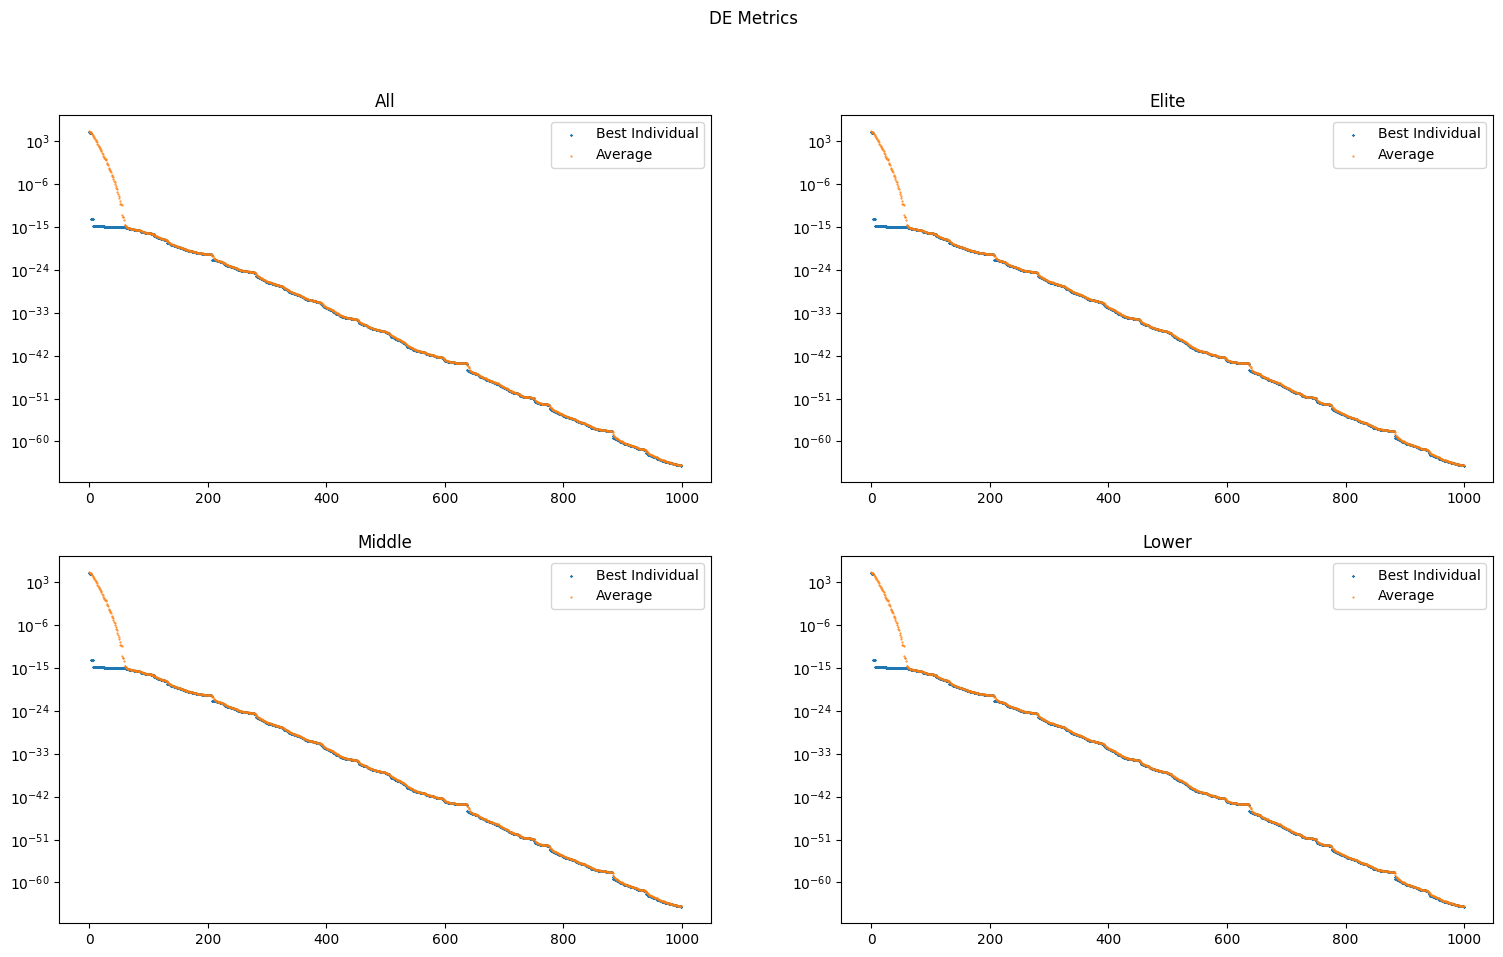

(array([ 7.73463195e-35, -4.15057163e-34,  1.75472563e-34, -2.40876337e-34,
        -9.77181540e-35,  2.29634449e-34,  1.95422472e-34, -3.76064920e-34,
         1.04948070e-34,  2.06226057e-34,  2.34404088e-34,  2.21497708e-34,
        -6.45922308e-35, -1.30860865e-34, -1.36915146e-35,  2.92757287e-34,
        -2.51687906e-33, -2.21961102e-36,  4.23016240e-34,  3.03910394e-34,
         4.07180154e-34,  2.83625000e-34,  5.88455798e-35, -1.03905439e-33,
         3.99648015e-34,  9.72103832e-35, -1.14312844e-34,  1.26216241e-35,
         1.37198579e-35,  5.94875830e-35]),
 8.895150502082948e-66)

In [54]:
def sphere(x: np.ndarray):
    return np.sum(np.apply_along_axis(lambda y: (y)**2, 0, x))

for i in range(30):
    metric_1 = MetricCollector(name="sphere", run_id=i)
    popsize = 40
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    n_iters = 1000

    res = ttp_de(
        f=sphere,
        popsize=popsize,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        bounds=bounds,
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.6,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_1,
        T=0,
        elitism_ratio=1,
        alpha=0.95,
        seed=i
    )
    metric_1.save_results()
    print(res[0].astype(str))

metric_1.compile_graphs()
res


Iteration 0: Best: 967450.9299453411, T: 0.0, (40, 30)
Iteration 100: Best: 1.9953612736012452e-13, T: 0.0, (40, 30)
Iteration 200: Best: 1.1114540346033278e-17, T: 0.0, (40, 30)
Iteration 300: Best: 4.563382663797276e-22, T: 0.0, (40, 30)
Iteration 400: Best: 6.864675116957366e-27, T: 0.0, (40, 30)
Iteration 500: Best: 3.103743260621376e-32, T: 0.0, (40, 30)
Iteration 600: Best: 4.3244455685804274e-38, T: 0.0, (40, 30)
Iteration 700: Best: 2.956924504113349e-44, T: 0.0, (40, 30)
Iteration 800: Best: 2.3426134065600177e-49, T: 0.0, (40, 30)
Iteration 900: Best: 1.3845375944875843e-54, T: 0.0, (40, 30)
[[-1.88523296e-31 -4.85081217e-31 -1.76925261e-31 ...  4.67199132e-32
   5.08175247e-32  4.28064859e-32]
 [-1.67981961e-31 -3.96043305e-31 -1.23175336e-31 ...  1.08118336e-31
   2.81771122e-32  6.98970099e-32]
 [-2.66746453e-31 -5.30232242e-31 -1.23689182e-31 ...  8.00240057e-32
   2.33264906e-32  4.68236476e-32]
 ...
 [-1.52480894e-31 -4.08743272e-31 -1.78499033e-31 ...  2.13012076e-32
 

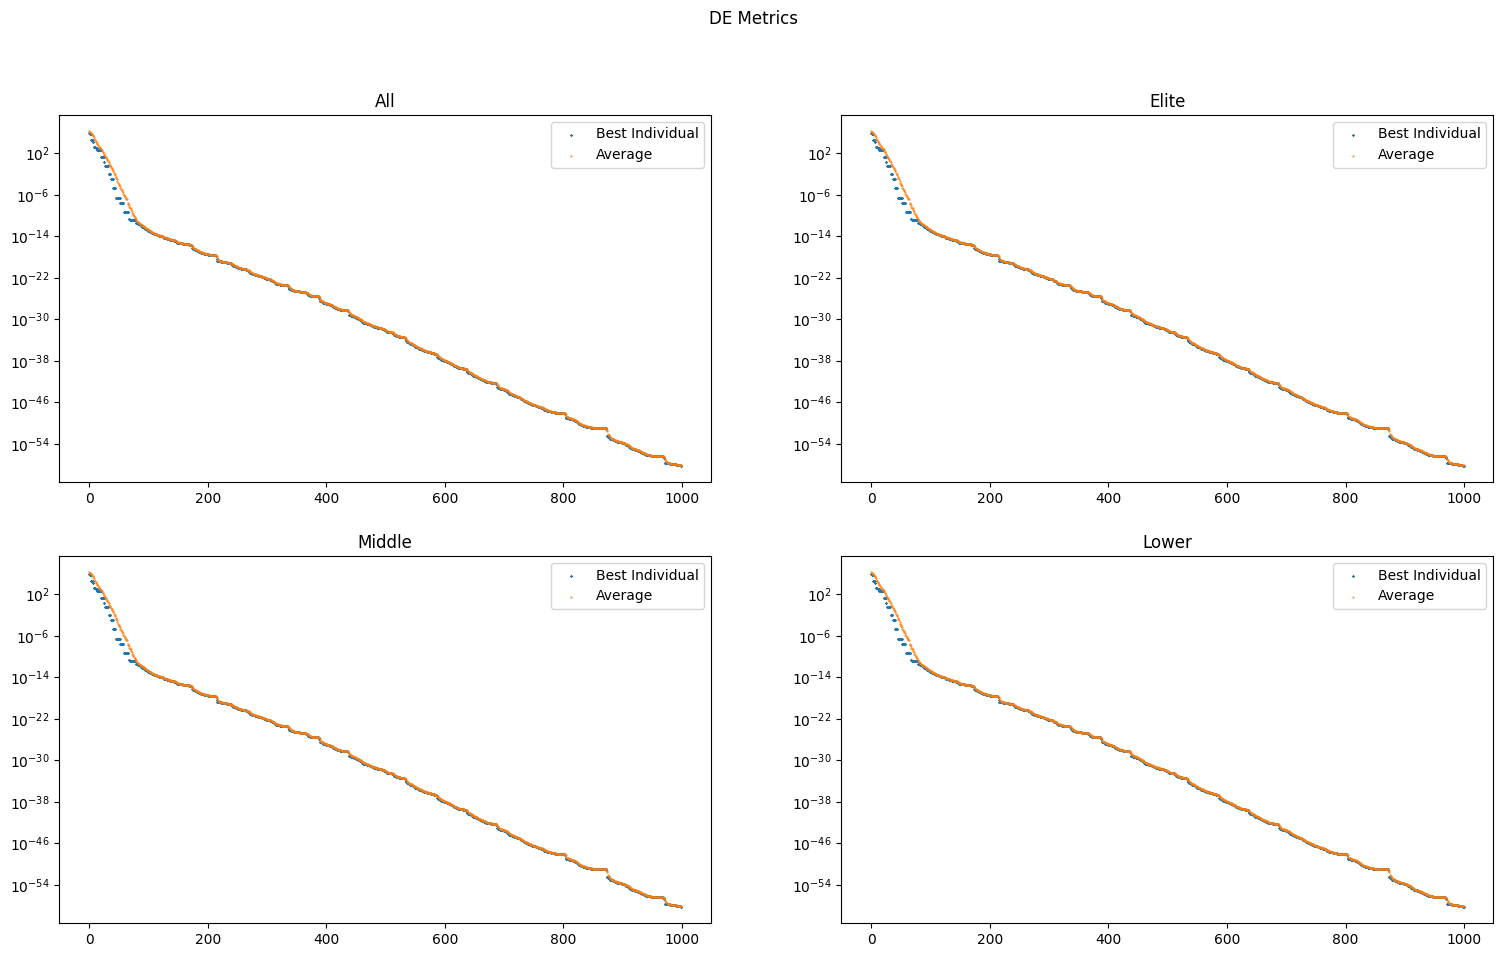

(array([-7.61049765e-31,  2.91286971e-31,  8.05649757e-32,  2.71793986e-31,
         7.24968940e-32, -1.67192111e-31,  2.02497097e-31,  1.52649739e-31,
         1.19494478e-31,  7.75724290e-32,  3.27541711e-33,  4.68932129e-32,
        -5.37090179e-32, -7.37684133e-31,  8.03166509e-34, -1.90588925e-30,
        -2.45661516e-32,  8.11628486e-33,  8.30945124e-32,  1.99978193e-32,
         1.36402870e-31, -1.14813047e-31,  9.84624147e-32,  1.89511085e-32,
        -3.20206228e-31, -5.11352355e-32,  5.74338898e-33, -8.39665180e-33,
         4.16356837e-32, -1.03283377e-31]),
 7.178852058331911e-59)

In [55]:
def weighted_sphere(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += (i + 1) * (x[i]) ** 2
    return cost

for i in range(30):
    metric_weighted_sphere = MetricCollector(name="weighted_sphere", run_id=i)
    popsize = 40
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = ttp_de(
        f=weighted_sphere,
        popsize=popsize,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        bounds=bounds,
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method='BFGS', options={"maxiter": 10}).x,
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.6,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_weighted_sphere,
        T=0,
        seed=i
    )
    metric_weighted_sphere.save_results()
metric_weighted_sphere.compile_graphs()
res

Iteration 0: Best: 3110593.940493743, T: 0.0, (40, 30)
Iteration 100: Best: 6.343901161249885e-12, T: 0.0, (40, 30)
Iteration 200: Best: 1.6841550785761834e-13, T: 0.0, (40, 30)
Iteration 300: Best: 3.777905725582374e-14, T: 0.0, (40, 30)
Iteration 400: Best: 2.7950576110649194e-15, T: 0.0, (40, 30)
Iteration 500: Best: 4.991508097911797e-16, T: 0.0, (40, 30)
Iteration 600: Best: 2.526585354101642e-16, T: 0.0, (40, 30)
Iteration 700: Best: 7.622782868695848e-17, T: 0.0, (40, 30)
Iteration 800: Best: 1.4113322809525383e-17, T: 0.0, (40, 30)
Iteration 900: Best: 7.612383810577876e-19, T: 0.0, (40, 30)
[[-1.61122585e-10  2.22658777e-10 -3.11027762e-11 ...  5.71019173e-12
   1.70316091e-11 -1.94733590e-12]
 [-1.61122540e-10  2.29550693e-10 -2.92498089e-11 ...  4.55700201e-12
   1.56595156e-11  1.16891233e-12]
 [-1.61123091e-10  2.34108779e-10 -3.07166216e-11 ... -1.51218999e-11
   1.51693707e-11  2.11049317e-12]
 ...
 [-1.61122585e-10  2.22658777e-10 -3.11027762e-11 ...  5.71019173e-12
   

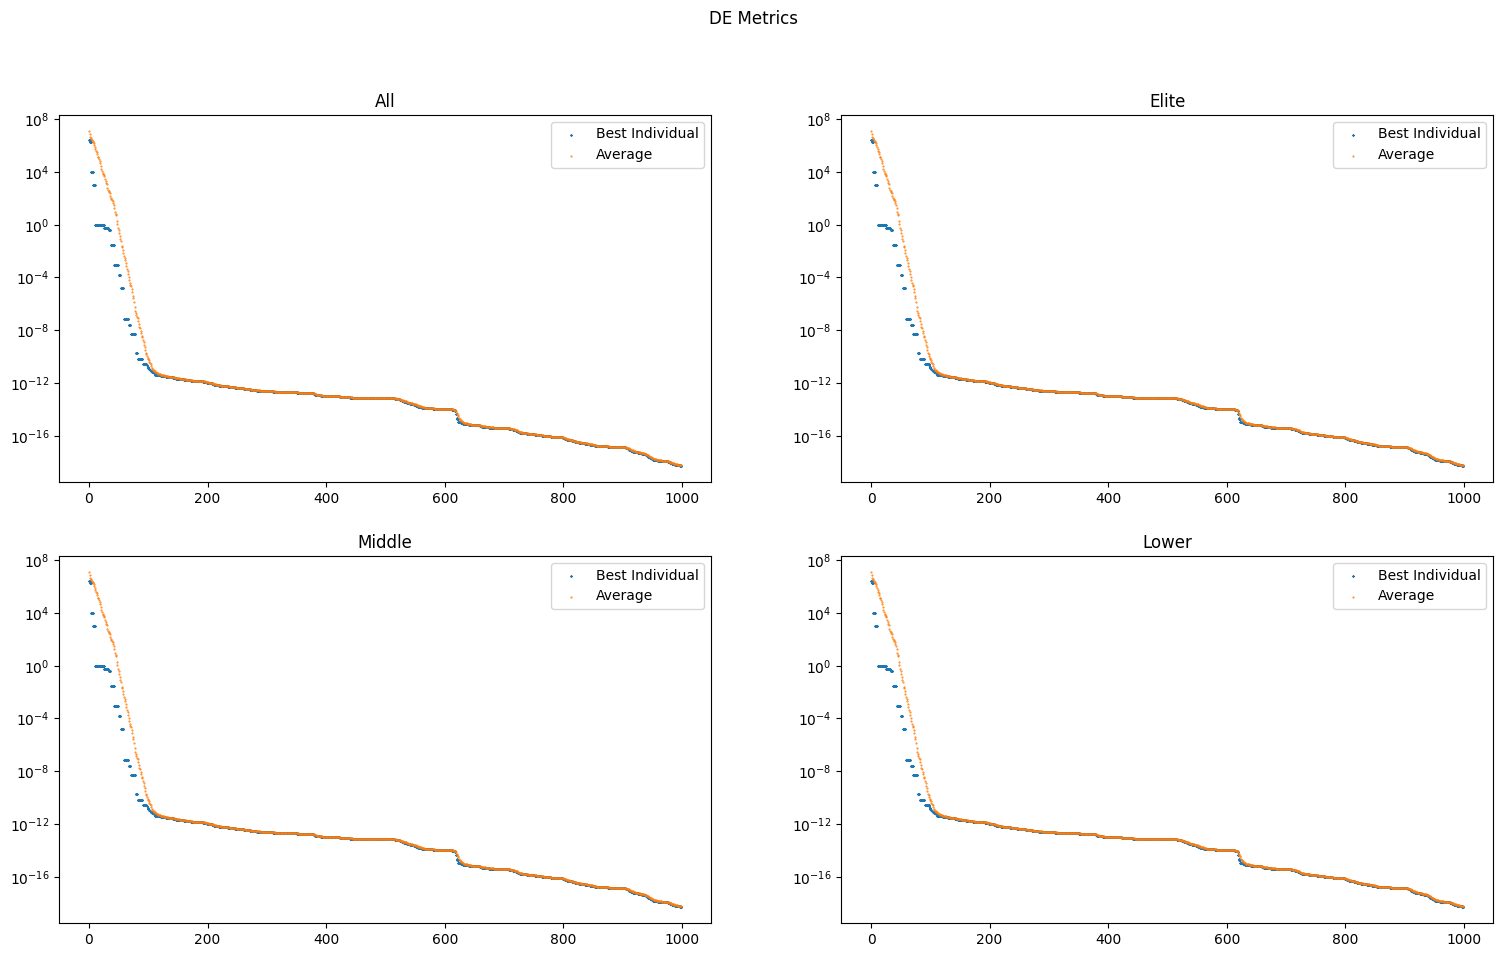

(array([ 2.11993528e-10, -2.20787258e-11, -3.39542300e-10,  4.63374056e-10,
        -5.64459815e-10,  3.11613885e-10, -1.37583311e-10,  1.49701276e-10,
        -1.33101977e-10,  8.55450337e-11, -4.00017237e-11, -4.94739149e-11,
         2.09083898e-11, -8.25642508e-12,  9.77112009e-11,  7.26278377e-11,
        -2.71418448e-10,  2.29114336e-10, -7.43466900e-12, -5.42027103e-11,
        -1.88912573e-10,  3.20456184e-10, -4.35443178e-11, -1.38491000e-10,
        -2.31627532e-11,  3.03450070e-10, -4.08356184e-10,  1.70783096e-10,
         1.43059939e-10, -2.06503428e-10]),
 5.226325861223755e-19)

In [56]:
def schwefel_1_2(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.sum(x[:i + 1]) ** 2
    return cost

for i in range(30):
    metric_schwefel_1_2 = MetricCollector(name="schwefel_1_2", run_id=i)
    popsize = 40
    d = 30
    bounds = [(-500, 500) for _ in range(d)]
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = ttp_de(
        f=schwefel_1_2,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method='BFGS', options={"maxiter": 10}).x,
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.8,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_schwefel_1_2,
        T=0,
        update_every_iter=5,
        alpha=0.9,
        elitism_ratio=0.6,
        seed=i
    )
    metric_schwefel_1_2.save_results()
metric_schwefel_1_2.compile_graphs()
res

In [94]:
def schwefel_2_3(x: np.ndarray):
    cost = 418.9829 * x.shape[0] - np.sum(np.apply_along_axis(lambda y: y * np.sin(np.sqrt(np.abs(y))), 0, x))
    return cost

for i in range(30):
    np.random.seed(i)
    metric_schwefel_2_3 = MetricCollector(name="schwefel_2_3", run_id=i)
    popsize = 40
    d = 30
    bounds = [(-500, 500) for _ in range(d)]
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = ttp_de(
        f=schwefel_2_3,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method='BFGS', options={"maxiter": 5}).x,
        exact_gradient_prob=0.05,
        differential_factor=1,
        crossover_prob=0.1,
        n_iter=n_iters,
        T=100,
        elitism_ratio=0.5,
        metric=metric_schwefel_2_3,
        vtr=1,
        seed=i
    )
    metric_schwefel_2_3.save_results()
metric_schwefel_2_3.compile_graphs()
res

Iteration 0: Best: 10988.518109649915, T: 950.0, (40, 30)
Iteration 100: Best: 2337.8077091255927, T: 568.8000922764597, (40, 30)
Iteration 200: Best: 2198.7057470002856, T: 340.5616262881148, (40, 30)
Iteration 300: Best: 2198.7057469773463, T: 203.9068257457904, (40, 30)
Iteration 400: Best: 2198.7057469773445, T: 122.08654873684794, (40, 30)
Iteration 500: Best: 2198.7057469773445, T: 73.09772651287747, (40, 30)
Iteration 600: Best: 2198.7057469773445, T: 43.76630903760434, (40, 30)
Iteration 700: Best: 2198.7057469773445, T: 26.204505914936206, (40, 30)
Iteration 800: Best: 2198.7057469773445, T: 15.68960566576289, (40, 30)


KeyboardInterrupt: 

Iteration 0: Best: 1.0, T: 0.0, (40, 2)
Iteration 100: Best: 0.0, T: 0.0, (40, 2)
Iteration 200: Best: 0.0, T: 0.0, (40, 2)
Iteration 300: Best: 0.0, T: 0.0, (40, 2)
Iteration 400: Best: 0.0, T: 0.0, (40, 2)
Iteration 500: Best: 0.0, T: 0.0, (40, 2)
Iteration 600: Best: 0.0, T: 0.0, (40, 2)
Iteration 700: Best: 0.0, T: 0.0, (40, 2)
Iteration 800: Best: 0.0, T: 0.0, (40, 2)
Iteration 900: Best: 0.0, T: 0.0, (40, 2)
[[3.14159265 3.14159265]
 [3.14159266 3.14159265]
 [3.14159265 3.14159265]
 [3.14159265 3.14159265]
 [3.14159265 3.14159266]
 [3.14159265 3.14159266]
 [3.14159265 3.14159265]
 [3.14159266 3.14159265]
 [3.14159265 3.14159265]
 [3.14159265 3.14159266]
 [3.14159265 3.14159265]
 [3.14159265 3.14159265]
 [3.14159265 3.14159265]
 [3.14159265 3.14159266]
 [3.14159265 3.14159265]
 [3.14159265 3.14159265]
 [3.14159266 3.14159265]
 [3.14159265 3.14159265]
 [3.14159265 3.14159265]
 [3.14159265 3.14159265]
 [3.14159266 3.14159265]
 [3.14159265 3.14159265]
 [3.14159265 3.14159266]
 [3.141

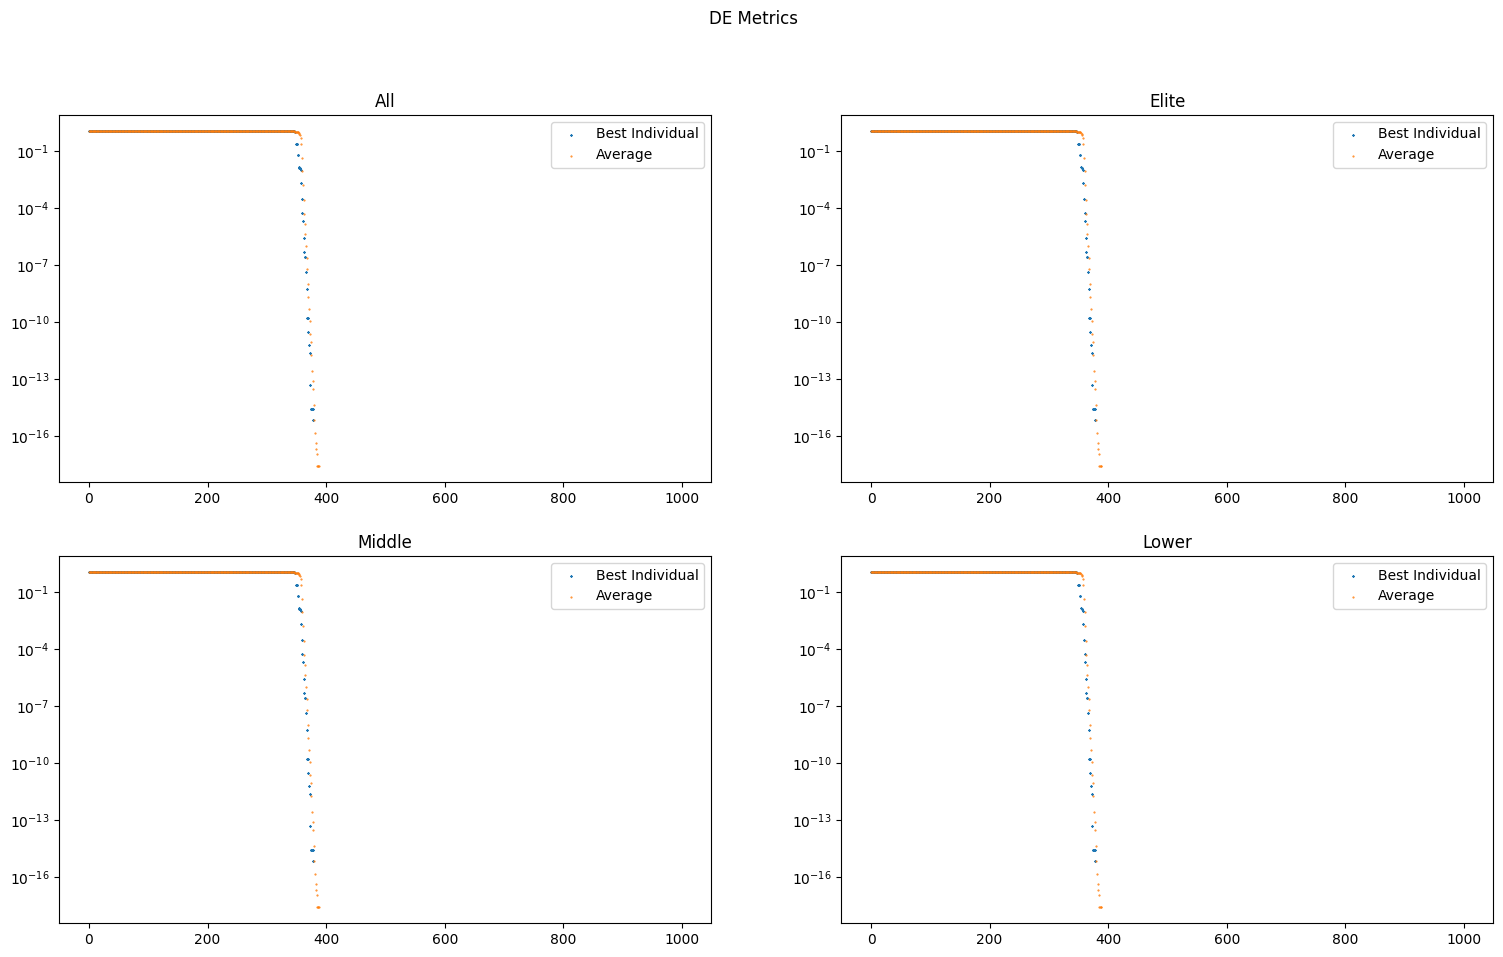

(array([3.14159265, 3.14159266]), 0.0)

In [58]:
for i in range(30):
    easom = lambda x: bf.Easom()(x) + 1
    np.random.seed(i)
    metric_easom = MetricCollector(name="easom", run_id=i)
    popsize = 40
    d = 2
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)

    res = ttp_de(
        f=easom,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method='BFGS', options={"maxiter": 10}).x,
        exact_gradient_prob=0.0,
        differential_factor=0.5,
        crossover_prob=0.9,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_easom,
        T=0,
        seed=i
    )
    metric_easom.save_results()
metric_easom.compile_graphs()
res

Iteration 0: Best: 458709.73750415025, T: 0.0, (40, 30)
Iteration 100: Best: 1.859242624915954e-14, T: 0.0, (40, 30)
Iteration 200: Best: 8.3803988894341355e-19, T: 0.0, (40, 30)
Iteration 300: Best: 3.4635040391930166e-24, T: 0.0, (40, 30)
Iteration 400: Best: 1.425998904004926e-28, T: 0.0, (40, 30)
Iteration 500: Best: 9.19323323239775e-33, T: 0.0, (40, 30)
Iteration 600: Best: 9.495034794865433e-36, T: 0.0, (40, 30)
Iteration 700: Best: 1.7195411264038e-42, T: 0.0, (40, 30)
Iteration 800: Best: 2.2069600721187283e-48, T: 0.0, (40, 30)
Iteration 900: Best: 2.178617180988134e-53, T: 0.0, (40, 30)
[[ 1.44334639e-31 -1.49758181e-32 -4.27189724e-33 ... -5.18446665e-31
   3.01989650e-31  2.34601347e-31]
 [-2.83007033e-31 -3.82907443e-32 -3.19909611e-32 ... -6.76894961e-31
   7.28195379e-31 -2.34624930e-30]
 [-3.81699158e-33 -1.11548822e-31 -5.15319537e-32 ... -1.15237654e-30
  -4.54588912e-31  5.43410296e-31]
 ...
 [ 2.91134026e-31  3.79875037e-32  1.41308096e-32 ... -7.67212283e-31
   3.

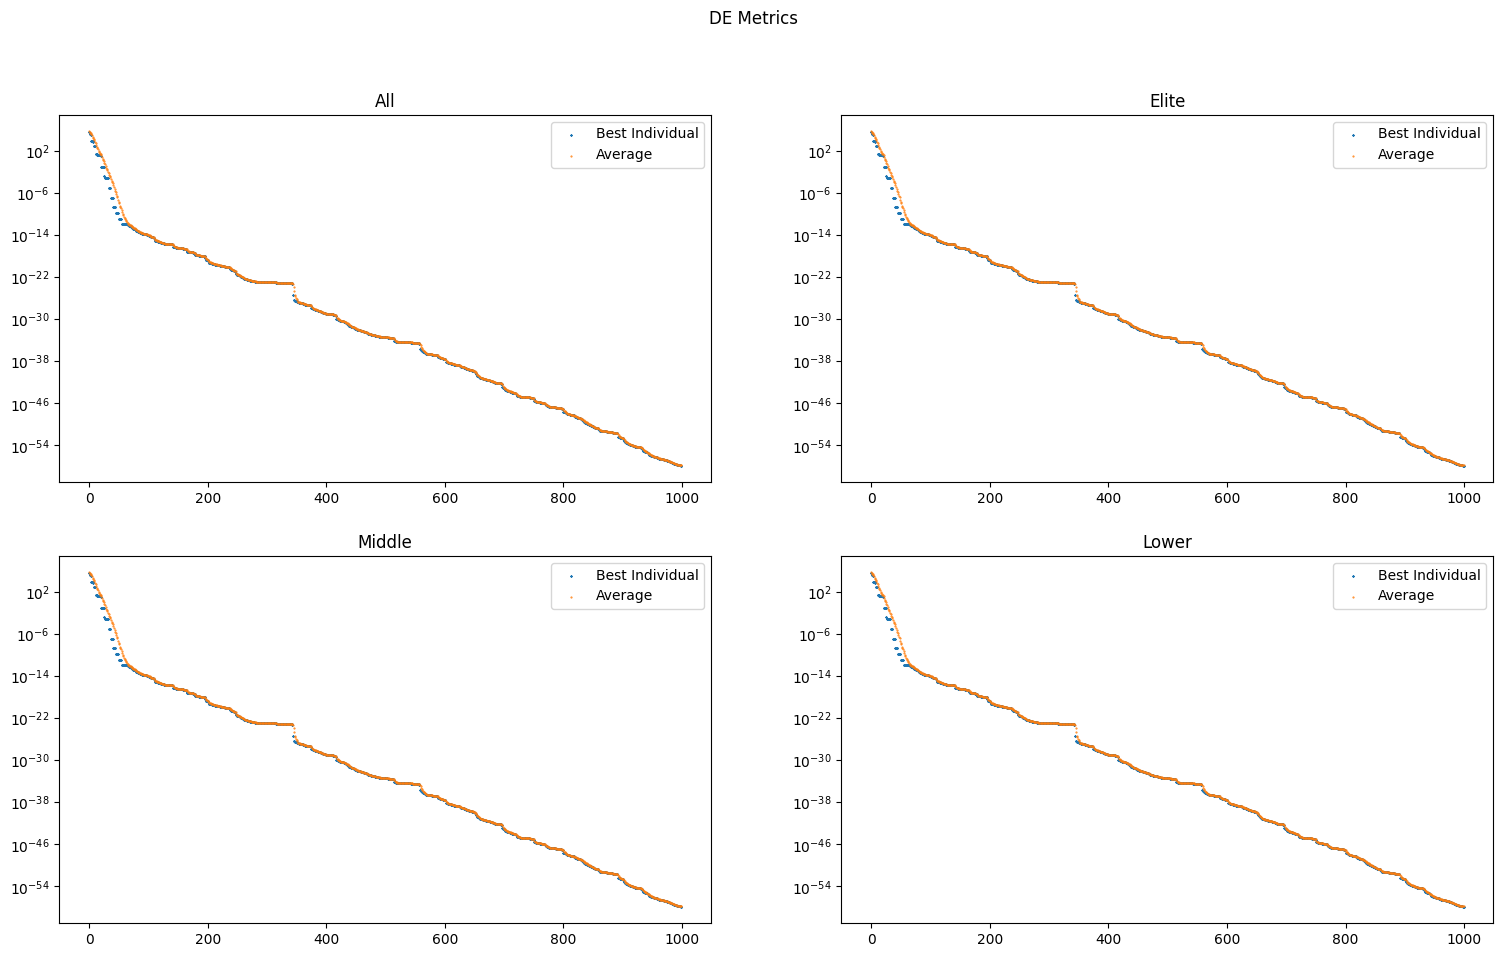

(array([ 6.47306015e-32, -2.74847656e-31,  2.08230396e-31,  1.02284157e-31,
         2.36715918e-31,  1.32112895e-31, -1.00054958e-32, -3.27111944e-32,
         3.77226681e-31,  1.54831435e-32,  1.64554167e-31,  8.08782776e-32,
         3.34340538e-31, -2.50380974e-30, -2.33123060e-32, -1.89558491e-32,
        -3.34407115e-32,  8.50400560e-31, -6.89288517e-31, -1.23763711e-31,
        -1.08165130e-30,  8.19801503e-32, -2.19980075e-31,  2.43457549e-31,
         2.86904976e-31,  1.75279660e-31, -1.09664881e-31, -1.73465564e-31,
         7.48527217e-31, -1.54219415e-30]),
 1.5026891368540665e-58)

In [59]:
def rotated_hyper_ellipsoid(x: np.ndarray):
    # rotated hyper ellipsoid
    cost = 0
    for i in range(x.shape[0]):
        cost += np.sum(np.apply_along_axis(lambda y: (y)**2, 0, x[:i+1]))
    return cost

for i in range(30):
    np.random.seed(i)
    metric_5 = MetricCollector(name="rotated_hyper_ellipsoid", run_id=i)
    bounds = [(-65.536, 65.536) for _ in range(30)]
    d = 30
    popsize = 40
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = ttp_de(
        f=rotated_hyper_ellipsoid,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method='BFGS', options={"maxiter": 10}).x,
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.7,
        n_iter=n_iters,
        metric=metric_5,
        T=0,
        seed=i
    )
    metric_5.save_results()
metric_5.compile_graphs()
res

I: 0
Iteration 0: Best: 7400.86336825752, T: 950.0, (40, 30)
Iteration 100: Best: 14.910038718097061, T: 568.8000922764597, (40, 30)
Iteration 200: Best: 1.1941527718658282, T: 340.5616262881148, (40, 30)
Iteration 300: Best: 2.538542062847091e-07, T: 203.9068257457904, (40, 30)
Iteration 400: Best: 2.2185492024664143e-12, T: 122.08654873684794, (40, 30)
Iteration 500: Best: 1.990512990985589e-13, T: 73.09772651287747, (40, 30)
Iteration 600: Best: 7.812544939313027e-14, T: 43.76630903760434, (40, 30)
Iteration 700: Best: 9.289280650954134e-16, T: 26.204505914936206, (40, 30)
Iteration 800: Best: 7.082160590358081e-16, T: 15.68960566576289, (40, 30)
Iteration 900: Best: 9.32787341111087e-17, T: 9.393946474175996, (40, 30)
[[1.         1.         1.         ... 1.         1.         1.00000001]
 [1.         1.         1.         ... 1.         1.         1.00000001]
 [1.         1.         1.         ... 1.         1.         1.00000001]
 ...
 [1.         1.         1.         ... 1.   

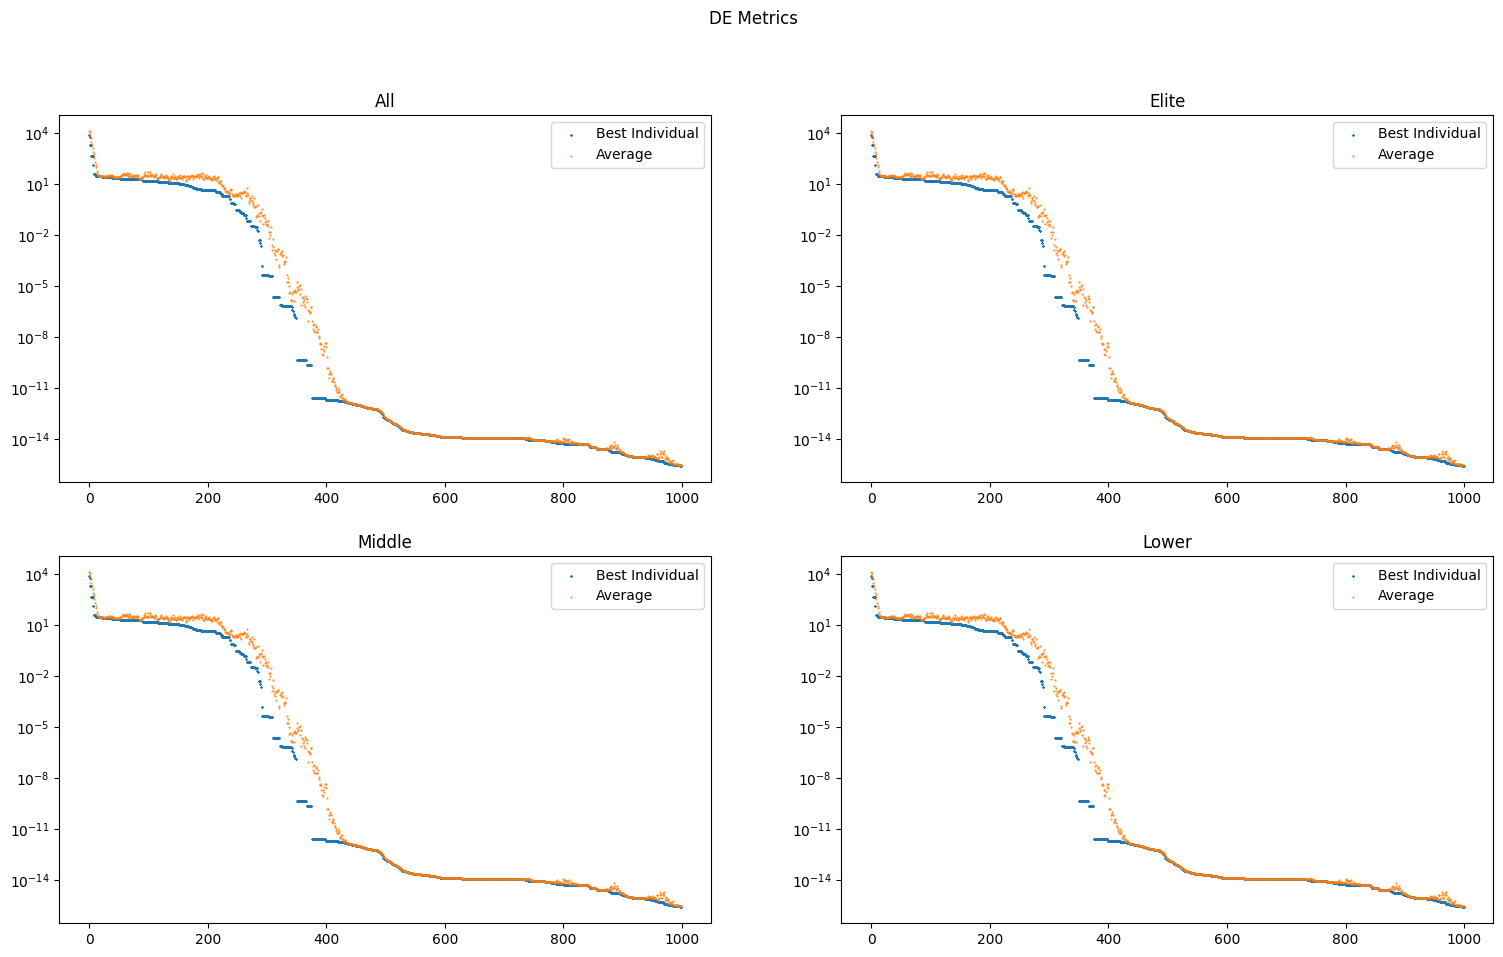

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99999999]),
 2.8196374942742776e-16)

In [87]:
def rosenbrock(x: np.ndarray):
    # rosenbrock
    cost = 0
    for i in range(x.shape[0] - 1):
        cost += 100 * (x[i + 1] - x[i]**2)**2 + (x[i] - 1)**2
    return cost

for i in range(30):
    print("====================")
    print(f"I: {i}")
    print("====================")
    metric_rosen = MetricCollector(name="rosenbrock", run_id=i)
    bounds = [(-2.048, 2.048) for _ in range(30)]
    d = 30
    n_iters = 1000
    popsize = 40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = ttp_de(
        f=rosenbrock,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method='BFGS', options={"maxiter": 10}).x,
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.8,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_rosen,
        T=1000,
        update_every_iter=10,
        elitism_ratio=0.6,
        seed=i
    )
    metric_rosen.save_results()
metric_rosen.compile_graphs()
res

Iteration 0: Best: 591.9422542313703, T: 95.0, (40, 30)
Iteration 100: Best: 1.708239105724374e-10, T: 56.880009227645964, (40, 30)
Iteration 200: Best: 5.6566196171559113e-11, T: 34.05616262881148, (40, 30)
Iteration 300: Best: 5.784261958297066e-14, T: 20.390682574579035, (40, 30)
Iteration 400: Best: 0.0, T: 12.208654873684791, (40, 30)
Iteration 500: Best: 0.0, T: 7.309772651287744, (40, 30)
Iteration 600: Best: 0.0, T: 4.376630903760432, (40, 30)
Iteration 700: Best: 0.0, T: 2.620450591493621, (40, 30)
Iteration 800: Best: 0.0, T: 1.5689605665762896, (40, 30)
Iteration 900: Best: 0.0, T: 0.9393946474176, (40, 30)
[[ 1.33682581e-10 -1.45422498e-08  9.67329785e-09 ...  1.49444012e-08
   6.87713863e-10  4.95290742e-08]
 [ 2.28498735e-09 -1.33792737e-08 -9.89730533e-09 ...  4.73076446e-09
  -4.50164000e-10  3.25393558e-08]
 [-9.91967787e-11 -1.45422498e-08  9.67329785e-09 ...  1.49444012e-08
   6.87713863e-10  5.20124624e-08]
 ...
 [-2.40514379e-09 -1.68222708e-08  1.99319447e-08 ... 

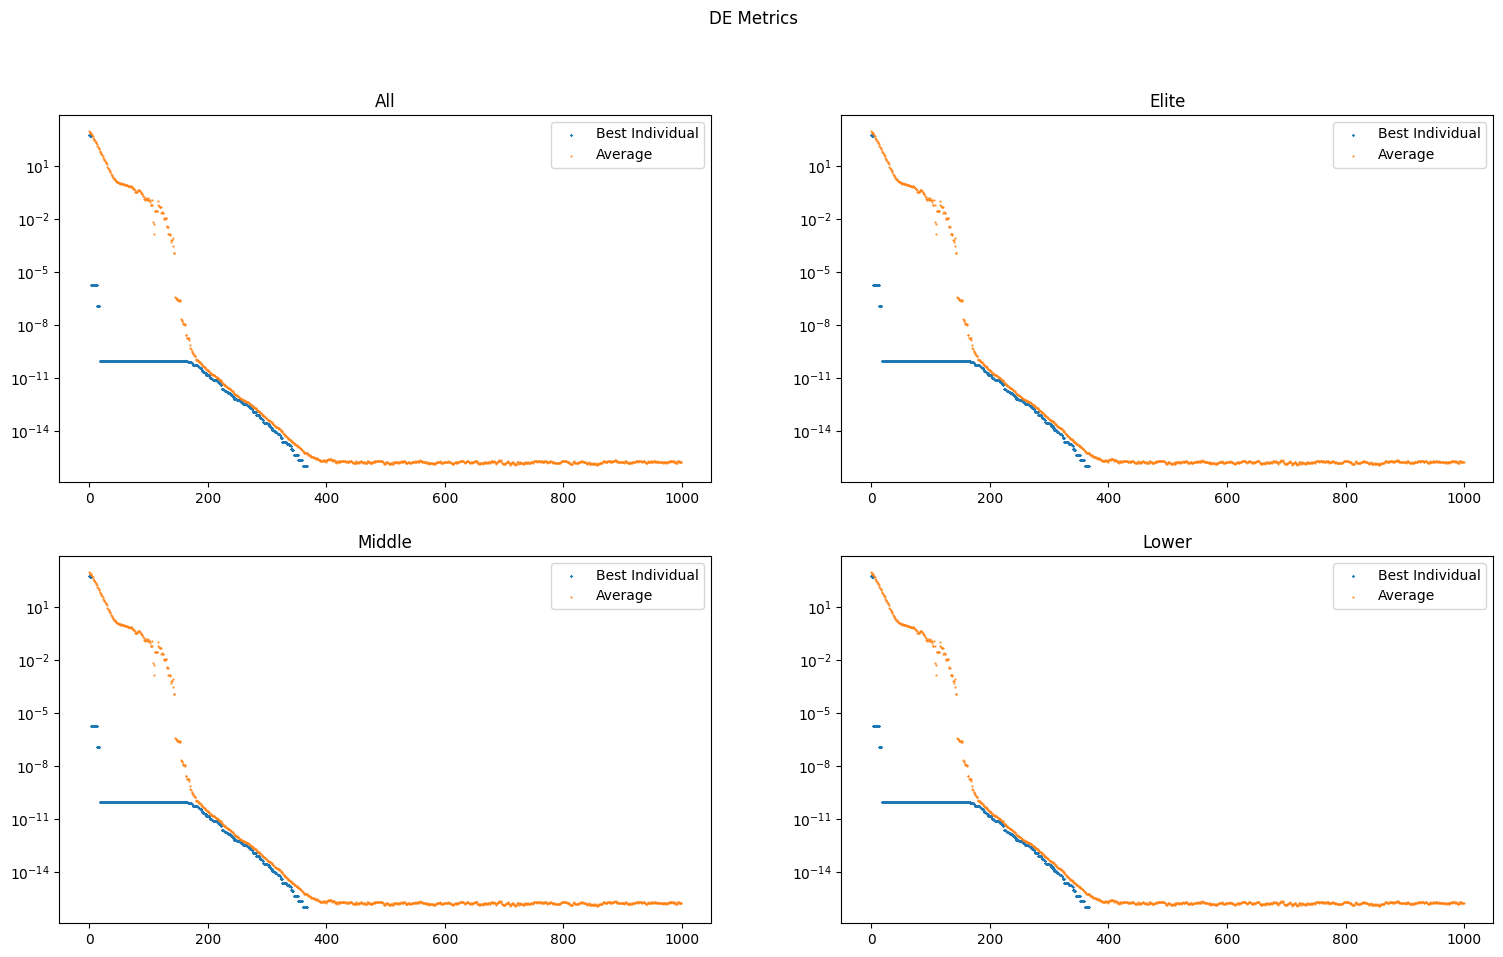

(array([-1.01791238e-08, -8.48390453e-09,  2.42563410e-10,  2.06341602e-08,
         1.43648234e-08, -1.57909582e-08, -1.00704545e-08,  2.26033513e-08,
         3.74476657e-09,  2.75390111e-08, -8.11741870e-11, -2.43223674e-08,
        -1.42720182e-08,  3.13853252e-09, -3.09331516e-08, -3.42710328e-08,
        -4.31938676e-08,  2.27567608e-08,  4.36871908e-08,  9.48414510e-10,
         1.64010605e-08, -4.04113276e-08, -1.49473207e-08,  2.75659134e-08,
         3.25420107e-08,  1.66368728e-08, -4.05049228e-08, -5.76607782e-09,
        -2.22922179e-08, -1.46443260e-08]),
 0.0)

In [61]:
def griewangk(x: np.ndarray):
    cost = 1/4000 * np.sum(np.apply_along_axis(lambda y: y**2, 0, x))
    prod = 1
    for i in range(x.shape[0]):
        prod *= np.cos(x[i] / np.sqrt(i + 1))
    return cost - prod + 1

for i in range(30):
    np.random.seed(i)
    metric_8 = MetricCollector(name="griewangk", run_id=i)
    d = 30
    bounds = [(-600, 600) for _ in range(d)]
    popsize=40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = ttp_de(
        f=griewangk,
        popsize=popsize,
        bounds=bounds,
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method='L-BFGS-B', options={"maxiter": 10}).x,
        exact_gradient_prob=0.01,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        differential_factor=0.5,
        crossover_prob=0.2,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_8,
        T=100,
        seed=i
    )
    metric_8.save_results()
metric_8.compile_graphs()
res

Iteration 0: Best: 1.1535730904427648, T: 0.0, (40, 30)
Iteration 100: Best: 1.3683670784229367e-13, T: 0.0, (40, 30)
Iteration 200: Best: 4.404471317175492e-22, T: 0.0, (40, 30)
Iteration 300: Best: 3.30503927727656e-31, T: 0.0, (40, 30)
Iteration 400: Best: 7.2618679813763076e-40, T: 0.0, (40, 30)
Iteration 500: Best: 2.0436736887613457e-49, T: 0.0, (40, 30)
Iteration 600: Best: 1.815198546070291e-55, T: 0.0, (40, 30)
Iteration 700: Best: 7.238282434118717e-63, T: 0.0, (40, 30)
Iteration 800: Best: 2.9778850115371237e-71, T: 0.0, (40, 30)
Iteration 900: Best: 8.596864624360354e-78, T: 0.0, (40, 30)
[[-4.47200072e-86  1.69836990e-43  1.00410102e-30 ... -5.58592354e-04
  -4.84906745e-04  1.36322967e-03]
 [ 2.19709828e-86 -1.46616462e-43 -5.54410319e-29 ... -5.16597683e-04
  -3.80829351e-04  1.32935349e-03]
 [-2.56563418e-86  7.54504282e-44  6.33895955e-30 ... -6.65950649e-04
  -6.48129263e-04  1.34288447e-03]
 ...
 [-2.27039012e-86  2.50158134e-43  2.65135665e-29 ... -5.71746659e-04
  

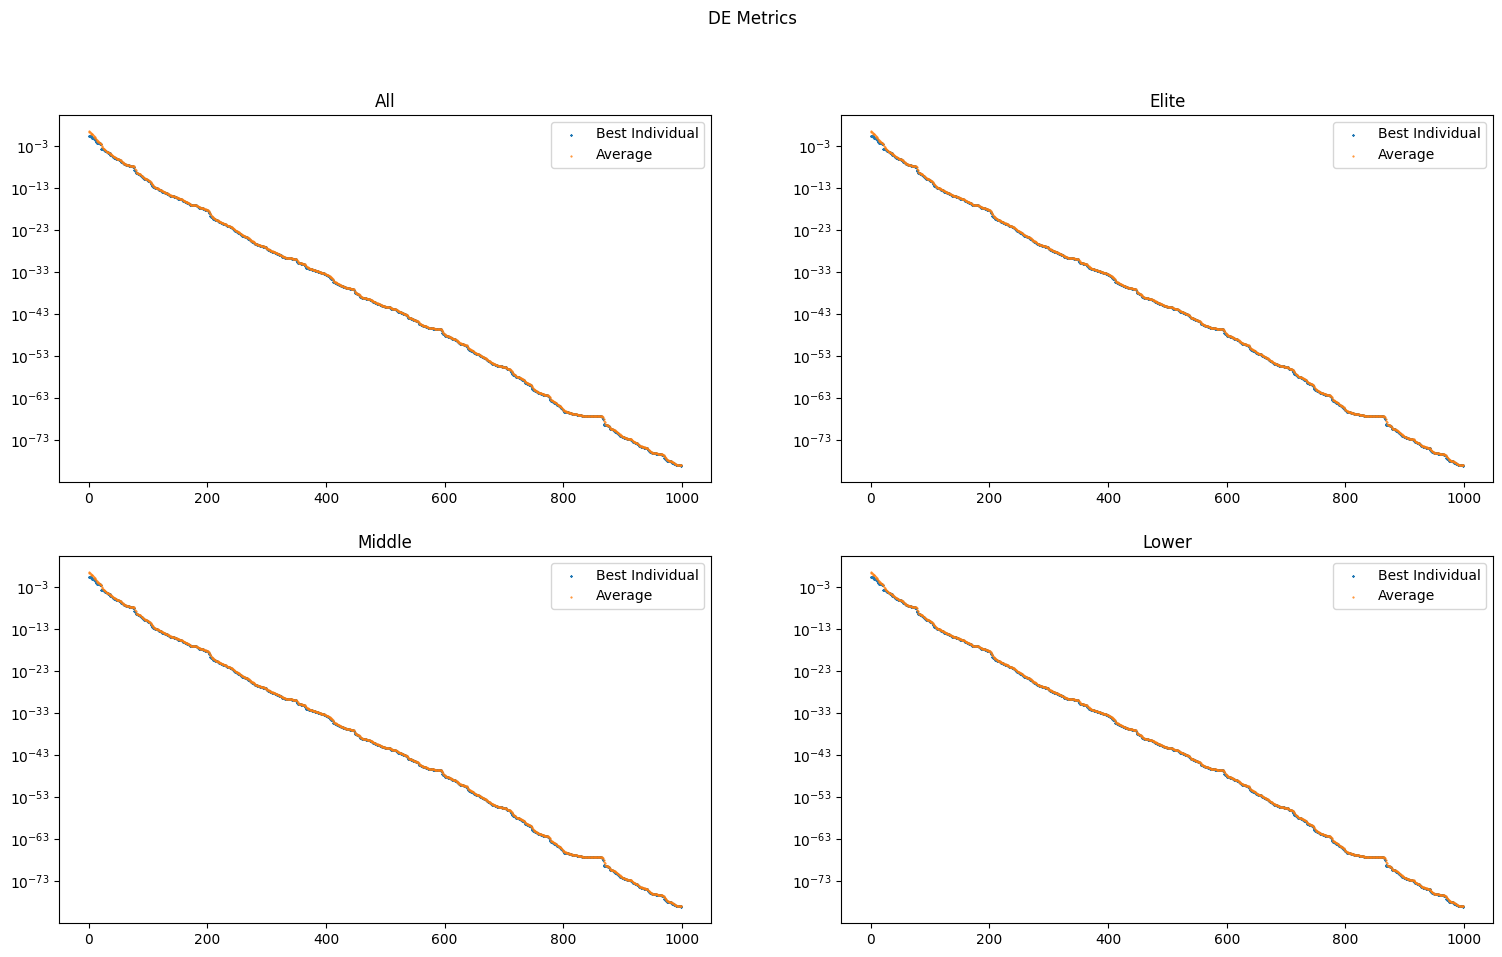

(array([ 6.41862805e-82,  1.16418392e-41, -4.41658412e-28,  3.89910700e-21,
         5.73721415e-17, -2.75812689e-14,  3.16115085e-12, -1.33258267e-12,
         1.21347198e-09,  8.69471699e-09, -4.71904292e-08, -1.61656993e-07,
         5.98622380e-07,  5.99949878e-07, -2.44756579e-06, -1.46325484e-06,
         1.08061101e-05,  2.65941545e-05, -4.88032717e-05,  4.85051968e-05,
        -9.02467817e-05,  1.77694414e-04,  1.18625464e-04,  3.55571439e-04,
         1.48630266e-04, -3.39789173e-04, -6.00711824e-04,  1.49953419e-03,
        -1.66452749e-03,  1.72581194e-03]),
 1.0498203642447532e-79)

In [62]:
def pow_sum(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.abs(x[i]) ** (i + 1)
    return cost

for i in range(30):
    np.random.seed(i)
    metric_9 = MetricCollector(name="pow_sum", run_id=i)
    d = 30
    bounds = [(-1, 1) for _ in range(d)]
    n_iters = 1000
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = ttp_de(
        f=pow_sum,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method='BFGS', options={"maxiter": 10}).x,
        exact_gradient_prob=0.001,
        differential_factor=0.5,
        crossover_prob=0.8,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_9,
        T=0,
        seed=i
    )
    metric_9.save_results()
metric_9.compile_graphs()
res

In [90]:
def ackley(x: np.ndarray):
    # ackley function
    cost = -20 * np.exp(-0.2 * np.sqrt(1/x.shape[0] * np.sum(np.apply_along_axis(lambda y: y**2, 0, x)))) - np.exp(1/x.shape[0] * np.sum(np.apply_along_axis(lambda y: np.cos(2 * np.pi * y), 0, x))) + 20 + np.exp(1)
    return cost

for i in range(30):
    np.random.seed(i)
    metric_14 = MetricCollector(name="ackley", run_id=i)
    d = 30
    bounds = [(-32.768, 32.768) for _ in range(d)]
    popsize=40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = ttp_de(
        f=ackley,
        popsize=popsize,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        bounds=bounds,
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method="BFGS", options={"maxiter": 5}).x,
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0.1,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_14,
        elitism_ratio=0.8,
        T=1000,
        alpha=0.95,
        seed=i
    )
    metric_14.save_results()
metric_14.compile_graphs()
res

Iteration 0: Best: 20.739353060582147, T: 950.0, (40, 30)
Iteration 100: Best: 7.957838093503327, T: 568.8000922764597, (40, 30)
Iteration 200: Best: 0.7005546891595746, T: 340.5616262881148, (40, 30)
Iteration 300: Best: 2.395055576087657e-08, T: 203.9068257457904, (40, 30)
Iteration 400: Best: 8.168651977058516e-09, T: 122.08654873684794, (40, 30)
Iteration 500: Best: 6.113727302192729e-10, T: 73.09772651287747, (40, 30)
Iteration 600: Best: 4.5293990780237436e-11, T: 43.76630903760434, (40, 30)
Iteration 700: Best: 2.9385383015778643e-12, T: 26.204505914936206, (40, 30)
Iteration 800: Best: 2.0294876890147862e-13, T: 15.68960566576289, (40, 30)
Iteration 900: Best: 2.531308496145357e-14, T: 9.393946474175996, (40, 30)
[[-3.63190716e-17 -3.21742094e-15 -5.72440743e-15 ... -6.00396746e-16
   2.69366026e-15  1.18023809e-17]
 [-3.42273704e-15 -3.01834733e-15 -8.45794163e-15 ...  1.04720141e-14
   4.60279260e-15 -1.47023678e-15]
 [-6.55237845e-15  6.39065387e-15 -1.33198337e-15 ... -2.97

KeyboardInterrupt: 

In [51]:
def rastrigin(x: np.ndarray):
    return 10 * x.shape[0] + np.sum(np.apply_along_axis(lambda y: y**2 - 10 * np.cos(2 * np.pi * y), 0, x))

for i in range(30):
    np.random.seed(i)
    metric_15 = MetricCollector(name="rastrigin", run_id=i)
    d = 30
    bounds = [(-600, 600) for _ in range(d)]
    popsize = 40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = ttp_de(
        f=rastrigin,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_prob=0.01,
        differential_factor=0.5,
        crossover_prob=0,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_15,
        T=100,
        update_every_iter=10,
        elitism_ratio=0.8,
        alpha=0.95,
        seed=i
    )
    metric_15.save_results()

metric_15.compile_graphs()
res

Iteration 0: Best: 2364036.723388786, T: 95.0, (40, 30)
Iteration 100: Best: 720.5039314675264, T: 56.880009227645964, (40, 30)
Iteration 200: Best: 108.56434841938693, T: 34.05616262881148, (40, 30)
Iteration 300: Best: 28.85379590583858, T: 20.390682574579035, (40, 30)
Iteration 400: Best: 10.947482003598111, T: 12.208654873684791, (40, 30)
Iteration 500: Best: 0.9960050365881443, T: 7.309772651287744, (40, 30)
Iteration 600: Best: 1.1368683772161603e-13, T: 4.376630903760432, (40, 30)
Iteration 700: Best: 5.684341886080802e-14, T: 2.620450591493621, (40, 30)
Iteration 800: Best: 5.684341886080802e-14, T: 1.5689605665762896, (40, 30)
Iteration 900: Best: 5.684341886080802e-14, T: 0.9393946474176, (40, 30)
[[ 1.69012261e-09  9.69267162e-10 -2.18781575e-09 ... -9.09724940e-09
  -1.04859023e-08 -9.02536476e-09]
 [ 3.31072901e-09  5.31700809e-09 -5.07695370e-09 ... -9.83206475e-09
  -9.20234559e-09 -5.32898942e-09]
 [-4.42523368e-09  5.98838878e-09  5.67035314e-09 ... -2.15949612e-09
  -

KeyboardInterrupt: 

(0.9980038377944496, [-31.978333625355454, -31.978335021953196])
Iteration 0: Best: 33.130643968857505, T: 95.0, (40, 2)
Iteration 100: Best: 0.9980038377944498, T: 56.880009227645964, (40, 2)
Iteration 200: Best: 0.9980038377944496, T: 34.05616262881148, (40, 2)
Iteration 300: Best: 0.9980038377944496, T: 20.390682574579035, (40, 2)
Iteration 400: Best: 0.9980038377944496, T: 12.208654873684791, (40, 2)
Iteration 500: Best: 0.9980038377944496, T: 7.309772651287744, (40, 2)
Iteration 600: Best: 0.9980038377944496, T: 4.376630903760432, (40, 2)
Iteration 700: Best: 0.9980038377944496, T: 2.620450591493621, (40, 2)
Iteration 800: Best: 0.9980038377944496, T: 1.5689605665762896, (40, 2)
Iteration 900: Best: 0.9980038377944496, T: 0.9393946474176, (40, 2)
(0.9980038377944496, [-31.978333625355454, -31.978335021953196])
Iteration 0: Best: 20.434589134221707, T: 95.0, (40, 2)
Iteration 100: Best: 0.9980038377944496, T: 56.880009227645964, (40, 2)
Iteration 200: Best: 0.9980038377944496, T: 3

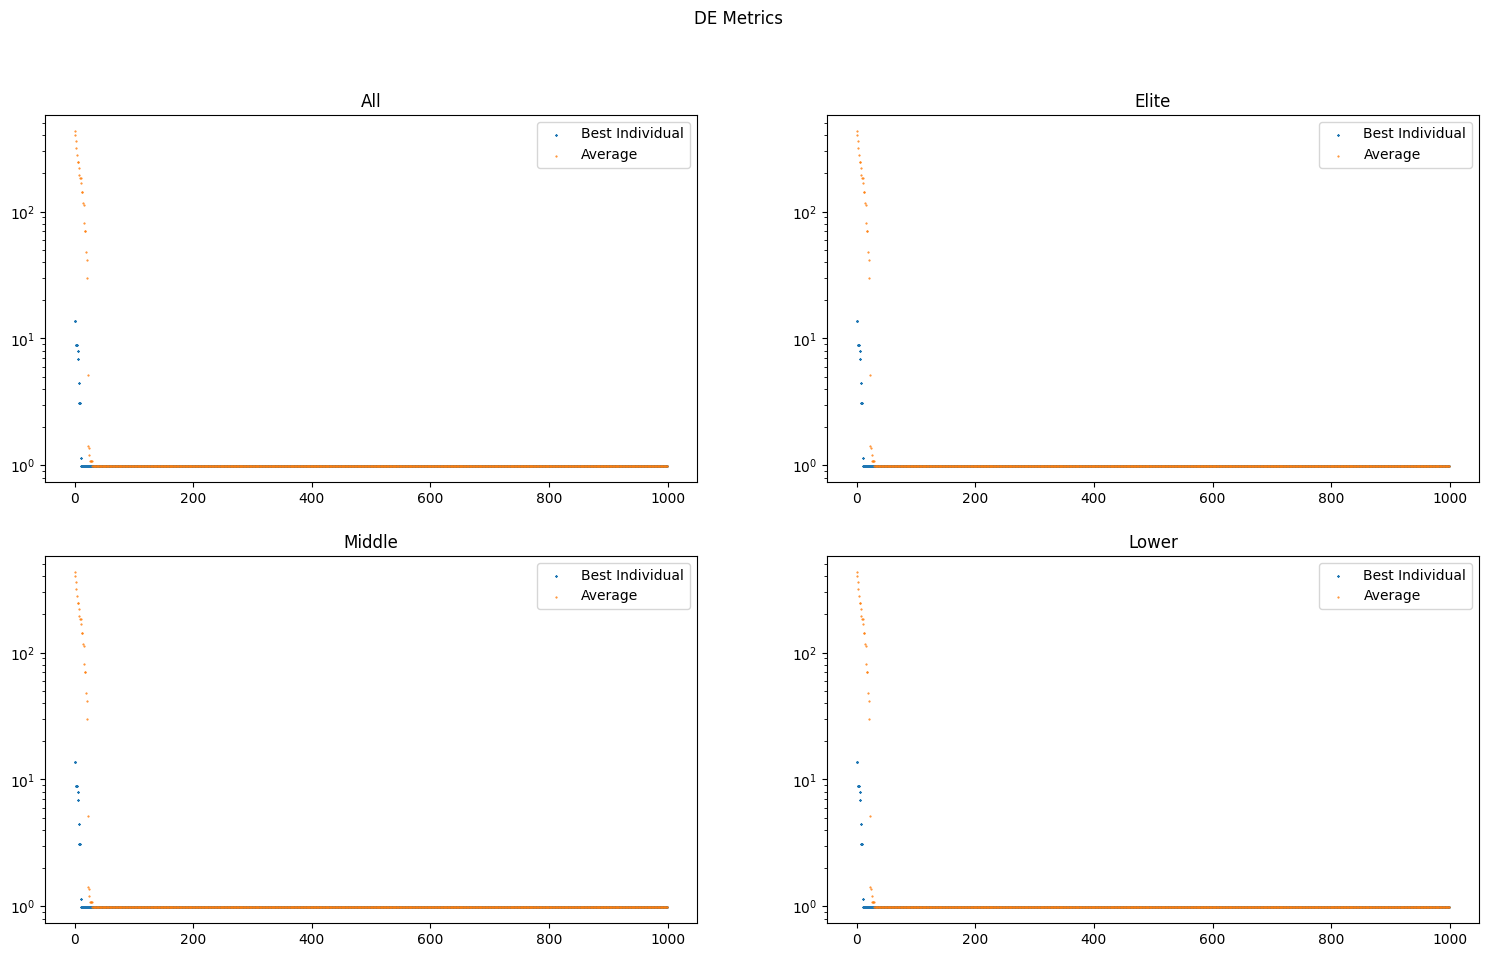

(array([-31.97833356, -31.9783348 ]), 0.9980038377944496)

In [293]:
for i in range(30):
    np.random.seed(i)
    metric_dejong_5 = MetricCollector(name="dejong_5", run_id=i)
    funcs = bf.DeJong5()
    print(funcs.minimum())
    bounds = [(-65.536, 65.636), (-65.536, 65.636)]
    popsize=40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=2, seed=i)
    res = ttp_de(
        f=funcs,
        popsize=popsize,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        bounds=bounds,
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method="L-BFGS-B", options={"maxiter": 10}).x,
        exact_gradient_prob=0.00,
        differential_factor=0.5,
        crossover_prob=0.0,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_dejong_5,
        T=100,
        vtr=0.999,
        seed=i
    )
    metric_dejong_5.save_results()
metric_dejong_5.compile_graphs()
res

Iteration 0: Best: 79, T: 0.0, (40, 30)
Iteration 100: Best: 0, T: 0.0, (40, 30)
Iteration 200: Best: 0, T: 0.0, (40, 30)
Iteration 300: Best: 0, T: 0.0, (40, 30)
Iteration 400: Best: 0, T: 0.0, (40, 30)
Iteration 500: Best: 0, T: 0.0, (40, 30)
Iteration 600: Best: 0, T: 0.0, (40, 30)
Iteration 700: Best: 0, T: 0.0, (40, 30)
Iteration 800: Best: 0, T: 0.0, (40, 30)
Iteration 900: Best: 0, T: 0.0, (40, 30)
Iteration 0: Best: 70, T: 0.0, (40, 30)
Iteration 100: Best: 0, T: 0.0, (40, 30)
Iteration 200: Best: 0, T: 0.0, (40, 30)
Iteration 300: Best: 0, T: 0.0, (40, 30)
Iteration 400: Best: 0, T: 0.0, (40, 30)
Iteration 500: Best: 0, T: 0.0, (40, 30)
Iteration 600: Best: 0, T: 0.0, (40, 30)
Iteration 700: Best: 0, T: 0.0, (40, 30)
Iteration 800: Best: 0, T: 0.0, (40, 30)
Iteration 900: Best: 0, T: 0.0, (40, 30)
Iteration 0: Best: 84, T: 0.0, (40, 30)
Iteration 100: Best: 0, T: 0.0, (40, 30)
Iteration 200: Best: 0, T: 0.0, (40, 30)
Iteration 300: Best: 0, T: 0.0, (40, 30)
Iteration 400: Best

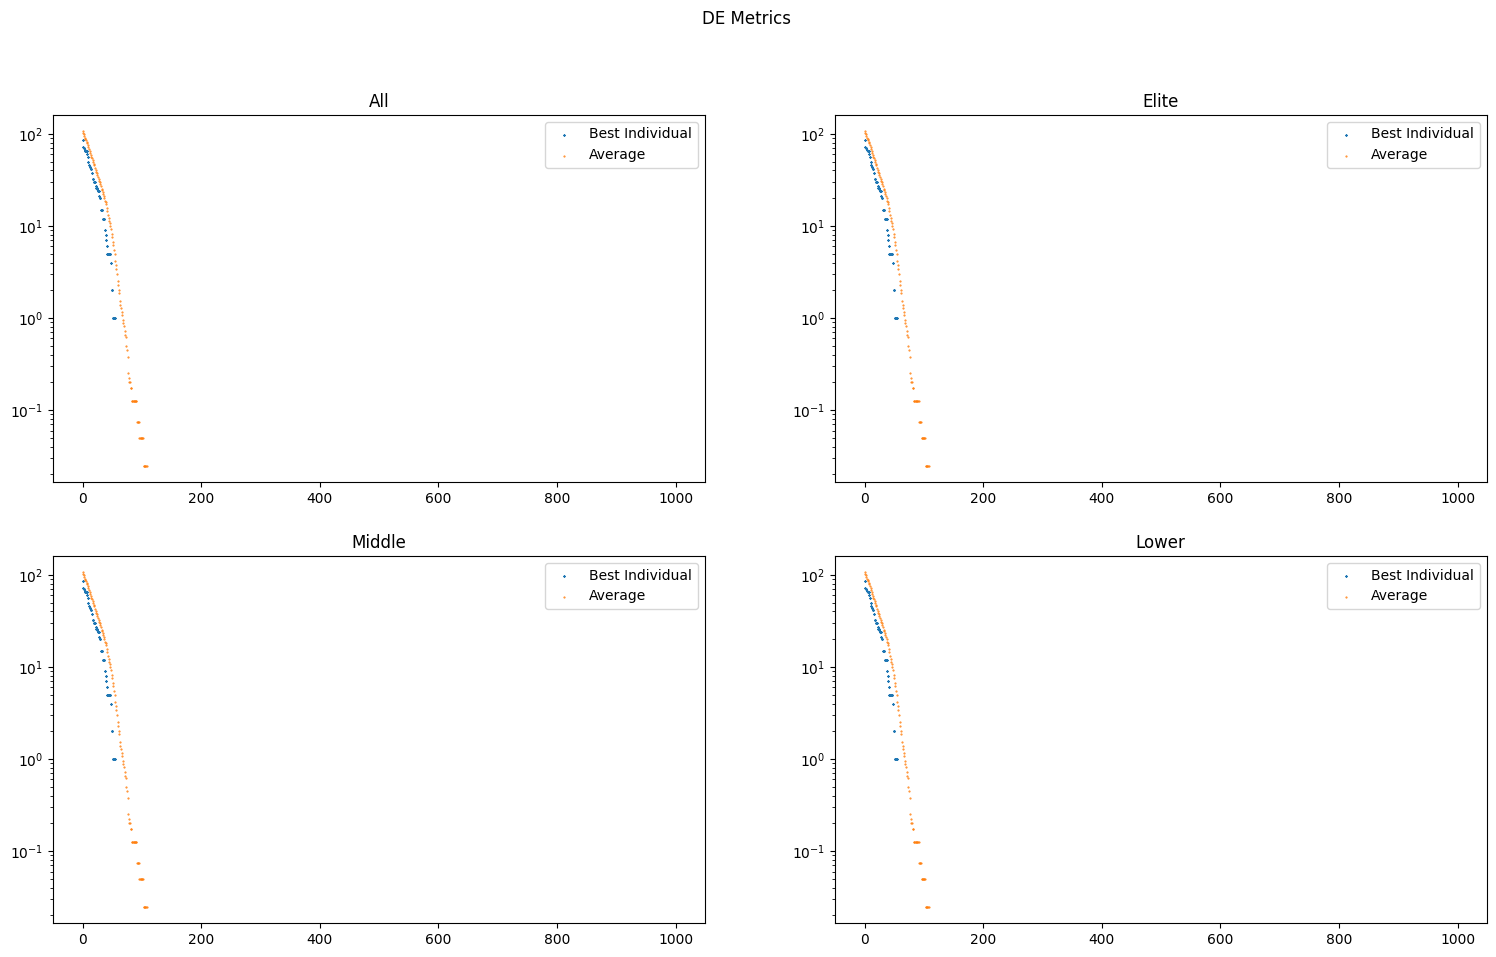

(array([-3.19570668, -3.46706838, -3.5       , -3.5       , -3.5       ,
        -3.17762401, -3.5       , -3.35156141, -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.10115223, -3.2620171 ,
        -3.5       , -3.38340809, -3.32604887, -3.46813171, -3.41433589,
        -3.5       , -3.5       , -3.5       , -3.18507941, -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.29803055, -3.5       ]),
 0)

In [291]:
for i in range(30):
    np.random.seed(i)
    dejong_3_func = lambda x: bf.DeJong3(n_dimensions=30)(x) + 120
    metric_dejong_3 = MetricCollector(name="dejong_3", run_id=i)
    dejong_3_stub = lambda x: dejong_3_func(x)
    bounds = [(-3.5, 3.8) for i in range(30)]
    popsize=40
    n_iters=1000
    sampler = stats.qmc.LatinHypercube(d=30, seed=i)
    res = ttp_de(
        f=dejong_3_stub,
        popsize=popsize,
        bounds=bounds,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        exact_gradient_method=lambda f, x: opt.minimize(f, x, method="BFGS", options={"maxiter": 10}).x,
        exact_gradient_prob=0.0,
        differential_factor=0.5,
        crossover_prob=0.1,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_dejong_3,
        T=0,
        seed=i
    )
    metric_dejong_3.save_results()
metric_dejong_3.compile_graphs()
res